# Project 3: Source Panel Method

#### Author: Jack Comey

##### Student ID: 915323775
##### Due Date: 11:59 PM Monday 09 NOV 2020

## 0 | Introduction

The source panel method is a method of fluid flow analysis operating under the potential flow model. A 2 dimensional shape (or a 3 dimensional shape of infinite length) is broken into _source sheets_, 2D lines that emit potential flow with unit strength per length $\lambda$. When the $\lambda$ values are correct, the dividing streamline will closely align with the surface of the object, allowing a program to analyze fluid flow around the body using exclusively potential flow superposition.

###### Code Imports and Basic Function Definition:

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  8 17:55:21 2020

@author: jack
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import integrate
import time
import math

%matplotlib inline

# Imports 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from math import *
plt.style.use("seaborn-bright")
%matplotlib inline

params={#FONT SIZES
    'axes.labelsize':30,#Axis Labels
    'axes.titlesize':30,#Title
    'font.size':28,#Textbox
    'xtick.labelsize':22,#Axis tick labels
    'ytick.labelsize':22,#Axis tick labels
    'legend.fontsize':24,#Legend font size
    'font.family':'serif',
    'font.fantasy':'xkcd',
    'font.sans-serif':'Helvetica',
    'font.monospace':'Courier',
    #AXIS PROPERTIES
    'axes.titlepad':2*6.0,#title spacing from axis
    'axes.grid':False,#grid on plot
    'figure.figsize':(12,12),#square plots
    'savefig.bbox':'tight',#reduce whitespace in saved figures#LEGEND PROPERTIES
    'legend.framealpha':0.5,
    'legend.fancybox':True,
    'legend.frameon':True,
    'legend.numpoints':1,
    'legend.scatterpoints':1,
    'legend.borderpad':0.1,
    'legend.borderaxespad':0.1,
    'legend.handletextpad':0.2,
    'legend.handlelength':1.0,
    'legend.labelspacing':0,}
mpl.rcParams.update(params)

#%%###########################

###
# REUSED FUNCTIONS
###

def NACAThicknessEquation(N, A, CA, num_points, *, use_other_x_points=0):
    """
    Generates a non-dimensionalized NACA airfoil given NACA numbers.

    Parameters
    ----------
    N : Ratio of max camber to chord length
    A : Location of max camber
    CA : Thickness ratio 
    num_points : Number of points for airfoil


    Returns
    -------
    x_non_dim_full : List of non-dimenionalized points from 0 to 1 to 0
    z : Airfoil non-dimensionalized z poisition from xc = 0 to 1 to 0
    zcc : Chord line

    """
    p = 0.1 * A
    m = 0.01 * N
    t = 0.01 * CA
    if use_other_x_points is not 0:
        x_non_dim = use_other_x_points
    else:
        x_non_dim = np.linspace(0, 1, num_points)
    
    ztc = x_non_dim*0
    
    # Find thickness relative to camber
    ztc += 0.2969 * (x_non_dim**0.5)
    ztc -= 0.1260 * (x_non_dim**1)
    ztc -= 0.3516 * (x_non_dim**2)
    ztc += 0.2843 * (x_non_dim**3)
    ztc -= 0.1015 * (x_non_dim**4)
    
    ztc *= t/0.2
    
    
    # Find camber line
    zcc = 0*x_non_dim
    try:
        for i in zip(*np.where(x_non_dim <= p)):
            zcc[i] = 2*p*x_non_dim[i]
            zcc[i] -= x_non_dim[i]**2
            zcc[i] *= m * p**-2
    
        for i in zip(*np.where(x_non_dim > p)):
            zcc[i] = 1 - 2*p
            zcc[i] += 2*p*x_non_dim[i]
            zcc[i] -= x_non_dim[i]**2
            zcc[i] *= m * (1-p)**-2

    except:
        zcc = 0*x_non_dim


    # Sum the two
    zup = zcc + ztc
    zdown = zcc - ztc
    
    x_non_dim = np.concatenate((x_non_dim, np.flip(x_non_dim)[1:]))
    z = np.concatenate((zup, np.flip(zdown)[1:]))
    return x_non_dim, z

def plothusly(ax, x, y, *, xtitle='', ytitle='',
              datalabel='', title='', linestyle='-',
              marker=''):
    """
    A little function to make graphing less of a pain.
    Creates a plot with titles and axis labels.
    Adds a new line to a blank figure and labels it.

    Parameters
    ----------
    ax : The graph object
    x : X axis data
    y : Y axis data
    xtitle : Optional x axis data title. The default is ''.
    ytitle : Optional y axis data title. The default is ''.
    datalabel : Optional label for data. The default is ''.
    title : Graph Title. The default is ''.

    Returns
    -------
    out : Resultant graph.

    """

    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_title(title)
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    plt.grid()
    plt.legend(loc='best')
    return out

def plothus(ax, x, y, *, datalabel='', linestyle = '-',
            marker = ''):
    """
    A little function to make graphing less of a pain

    Adds a new line to a blank figure and labels it
    """
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    plt.legend(loc='best')

    return out

def CalculateCn(Cplx, Cply, Cpux, Cpuy, *, c=1):
    left = np.trapz(Cply, Cplx)
    right = np.trapz(Cpuy, Cpux)
    out = (left - right)
    out /= c
    return out

def CalculateCa(Cplx, Cply, Cpux, Cpuy, xc, ztu, ztl,  *, c=1):
    gradu = np.gradient(ztu, xc)
    gradl = np.gradient(ztl, xc)
    
    graduvec = np.zeros((len(Cpux)))
    gradlvec = np.zeros((len(Cplx)))
    
    for i in range(len(graduvec)):
        graduvec[i] = np.interp(Cpux[i], xc, gradu)

    for i in range(len(gradlvec)):
        gradlvec[i] = np.interp(Cplx[i], xc, gradl)
    left = np.trapz(Cpuy*graduvec, Cpux)
    right = np.trapz(Cply*gradlvec, Cplx)

    
    out = (left - right)/c
    return out

## 1 | Flow Over a Non-Rotating Cylinder

For a non-rotating cylinder of arbitrary radius, discretize the cylinder using the source panel method. Use varying numbers of panels, and compare the effect of the number of panels on the accuracy of the solution by comparing the pressure distribution across the cylinder to an analytically derived solution. Numerically determine the error of the panel method solution as compared to the analtytical solution. Additionally, for a cylinder with 32 panels, plot the pressure contours, streamlines, and surface pressure gradient.

### 1.1 | Approach

In order to simplify **Problem 2**, a generalized method for solving panel flow should be made, as opposed to a specific method for the cylinders, and as such, _AeroPython Lesson 10_ was used as a reference. A ```Panel()``` object is to model a source panel, and has properties of the coordinates of the endpoints, and of the control point at the center of the panel. 

A function is made to construct a panel approximation of a cylinder of $N$ panels. A second function, ```PanelStrengthSolver```, creates a linear system of panel strengths according to the panel method equation in the equation section, and solves for each $\lambda$ value by relating the flow induced through each panel by every other panel, and the self-induced flow. A similar method is used to solve for tangential velocity, and the tangential velocity is used to find coefficient of pressure $C_P$.

To plot the error, a number of cylinders are generated from a list, and the error of each cylinder is recorded in an array, along with a number of panels. The error is then displayed in a log-log plot. 

For the additional plot, a velocity profile must be found. Using the same general purpose integral as used to solve for source strength and tangential velocity, $u$ and $v$ can be found by adjusting the input values accordingly. Velocity can then be used to solve for the pressure contour. Surface pressure gradient can be found by taking the gradient of the surface pressure data, using numpy's ```np.gradient()``` function.

### 1.2 | Equations

The source panel method is solved by the equation for the $i$-th panel:

$$\begin{equation}
    \frac{\lambda_i}{2} + \Sigma _{j=1, j\neq i} ^n \frac{\lambda_j}{2\pi} I_{i, j} + V_\infty cos \beta_i = 0
\end{equation}$$

where:

$$\begin{equation}
    I_{i, j} \int_j \frac{\partial}{\partial n} \ln r_{i,j} \, ds_j
\end{equation}$$

Source strength $\lambda_i$ is found using a system of linear equations:

$$\begin{equation}
    A\lambda = b
\end{equation}$$

for:
$$\begin{equation}
b_i = -V_\infty cos \beta_i
\end{equation}$$

Pressure is found as :

$$\begin{equation}
C_P = 1 - \frac{V^2}{V_\infty^2}
\end{equation}$$

Finally, the validity of the model can be checked by determining if there is a net change in the amount of fluid (that is, to see if mass is created or destroyed):

$$\begin{equation}
    \Sigma_{i=1}^{n} \lambda_i s_i = 0
\end{equation}$$
### 1.3 | Code and Results

The freestream fluid flow is defined as an object:

In [2]:
class Freestream():
    
    def __init__(self, u_inf, alpha=0):
        
        self.u_inf = u_inf
        self.alpha = alpha

This allows for any freestream properties to be called as an input to a function, with only the need for the object to be entered as the input.

The source panel is also defined as an object, and takes inputs for each panel endpoint, and calculates the centerpoint and angle of the panel. Note that the panels must be initialized in the clockwise direction, otherwise the analysis program will calculate strengths in the incorrect direction.

In [3]:
class Panel():
    
    def __init__(self, x1, y1, x2, y2):
        
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
        
        # Take the center points as the average of the two points
        
        self.xc = 0.5 * (x1 + x2)
        self.yc = 0.5 * (y1 + y2)
        
        self.length = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        self.strength = 0
        self.v_tan = 0
        self.surface_cp = 0
        
        
        # if x2 -x1 <= 0:
        #     self.beta = np.arccos((y2 - y1) / self.length)
        # elif x2 - x1 >= 0:
        #     self.beta = np.pi + np.arccos(-(y2 - y1) / self.length)
        
        if x2 - x1 <= 0.0:
            self.beta = math.acos((y2 - y1) / self.length)
        elif x2 - x1 > 0.0:
            self.beta = math.pi + math.acos(-(y2 - y1) / self.length)
        
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'

The function to define the cylinder geometry is created, and it outputs the points themselves, as well as a list of panels defining the cylinder:

In [4]:
def ConstructCylinder(xc, yc, R, N):
    
    xpoints = R * np.cos(np.linspace(0, 2*np.pi, N+1))
    ypoints = R * np.sin(np.linspace(0, 2*np.pi, N+1))
    
    panel_list = np.empty((N), dtype=object)
    for i in range(N):
        panel_list[i] = Panel(xpoints[i], ypoints[i], xpoints[i+1], ypoints[i+1])
    return xpoints, ypoints, panel_list


The panel strength solver is then defined. It solves for panel strength $\lambda_i$ for an arbitrary geometry, as long as the shape is closed. It modifies the list of panels, and then returns it.

In [5]:
def PanelStrengthSolver(freestream, panel_list):
    N = len(panel_list)
    A = np.zeros((N, N))
    
    # For every panel i
    for i, panel_i in enumerate(panel_list):
        
        # For every other panel j
        for j, panel_j in enumerate(panel_list):
            
            # Can't induce flow on itself
            if i == j:
                A[i, j] = 0.5
                
            else:
                # Flow induced on panel i by panel j
                 A[i, j] = 1 / (2*np.pi) * I(panel_i.xc,
                                             panel_i.yc,
                                             panel_j,
                                             np.cos(panel_i.beta),
                                             np.sin(panel_i.beta))
            
    solution_vector = np.zeros((N, 1))
    for i in range(N):
        solution_vector[i] = -freestream.u_inf * np.cos(freestream.alpha - panel_list[i].beta)
    
    strength_list = np.linalg.solve(A, solution_vector)
    for i, panel in enumerate(panel_list):
        panel.strength = strength_list[i]
    return panel_list

A solver for the tangential velocity is used to find the tangential velocity of fluid flow near the panel surface. It uses a similar format to the previous solver. It modifies the list and then returns it.

In [6]:
def PanelTangentSolver(freestream, panel_list):
    N = len(panel_list)
    A = np.zeros((N,N))
    
    # for every panel i
    for i, panel_i in enumerate(panel_list):
        
        # for every other panel j
        for j, panel_j in enumerate(panel_list):
            
            # It cannot effect itself:
            if i == j:
                A[i, j] = 0
            
            else:
                A[i, j] = 1 / (2 * np.pi) * I(panel_i.xc,
                                              panel_i.yc,
                                              panel_j,
                                              -1 * np.sin(panel_i.beta),
                                              np.cos(panel_i.beta))
    # Find output vector b
    b = np.zeros((N, 1))
    for i, panel in enumerate(panel_list):
        b[i] = freestream.u_inf * np.sin(freestream.alpha
                                         - panel.beta)
    strength_list = np.zeros((N, 1))
    for i, panel in enumerate(panel_list):
        strength_list[i] = panel.strength
    
    v_tan = np.dot(A, strength_list) + b
    
    for i, panel in enumerate(panel_list):
        panel.v_tan = v_tan[i]
    
    return panel_list

Both of these solvers rely on an integral function, which determines the effect of the fluid flow on panel $i$ from panel $j$. It is expressed as:

In [7]:
def I(x, y, panel, dxdz, dydz):

    integral_internal = lambda s: (((x - (panel.x1 - np.sin(panel.beta) * s)) * dxdz +
                                    (y - (panel.y1 + np.cos(panel.beta) * s)) * dydz) /
                                   (   (x - (panel.x1 - np.sin(panel.beta) * s))**2 +
                                    (y - (panel.y1 + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integral_internal, 0.0, panel.length)[0]

Finally, a function to solve for the surface pressure of the panel is used. It determines $C_P$ from freestream and tangential velocity.

In [8]:
def PanelPressureSolver(freestream, panel_list):
    
    for i, panel in enumerate(panel_list):
        panel.surface_cp = 1 - (panel.v_tan / freestream.u_inf)**2
        
    return panel_list

The first plot of surface pressure is found by iterating over a loop of panel numbers, and solving for surface pressure for each. At each loop, the error is calculated, and it is determined if the shape is valid or not.

Error for 8 terms is 0.32532257114214413
Sanity Check for N = 8 : [1.99840144e-15]
Error for 32 terms is 0.18880393810860951
Sanity Check for N = 32 : [4.99600361e-16]
Error for 128 terms is 0.04896912940181686
Sanity Check for N = 128 : [-5.55111512e-16]


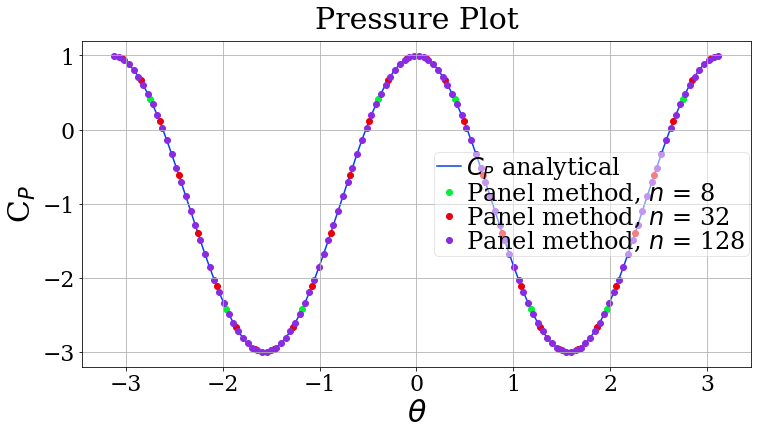

In [9]:
# Main
Nlist = [8, 32, 128]
fs = Freestream(1, 0)

# Create plot and add analytical solution. Can then add surface pressures for 
# each as part of a loop

fig, presplot = plt.subplots(figsize=(12, 6))

thetavec_analytical = np.linspace(-np.pi, np.pi, 1000)
cp_analytical = 1 - (-2*fs.u_inf*np.sin(thetavec_analytical) / fs.u_inf**2)**2
plothusly(presplot, 
          thetavec_analytical, 
          cp_analytical,
          title='Pressure Plot',
          xtitle=r'$\theta$',
          ytitle=r'C$_P$',
          datalabel=r'$C_P$ analytical')



for N in Nlist:
    
    # Construct Cylinder panels
    x_cylinder, y_cylinder, panel_list = ConstructCylinder(0, 0, 1, N)
    
    # Solve for all data
    panel_list = PanelStrengthSolver(fs, panel_list)
    panel_list = PanelTangentSolver(fs, panel_list)
    panel_list = PanelPressureSolver(fs, panel_list)
    
    # Plot discretized pressure
    
    thetavec = np.empty((N, 1))
    cpvec = np.empty((N, 1))
    for i, panel in enumerate(panel_list):
        thetavec[i] = np.arctan2(panel.yc, panel.xc)
        cpvec[i] = panel.surface_cp
    plothus(presplot, thetavec, cpvec, datalabel=fr'Panel method, $n$ = {N} ', linestyle='', marker='o')
    
    datavec = np.concatenate((thetavec, cpvec), axis=1)
    datavec = datavec[datavec[:, 0].argsort()]
    
    # Calculate error
    err = (np.trapz(cp_analytical,
                    thetavec_analytical)
           - np.trapz(datavec[:, 1],
                      datavec[:, 0]))
    
    print(f'Error for {N} terms is {err}')
    
    
    # Check to ensure that conservation of mass is true
    sumval = 0
    for i, panel in enumerate(panel_list):
        sumval += panel.strength * panel.length
        
    print(f'Sanity Check for N = {N} : {sumval}')

Note that the source panel method aligns closely with the analytical result, with some minor error. The geometry also appears to be closed, as the sum of panel strengths goes to zero (or close enough to zero).

Using a larger ```Nlist```, the error can be plotted as a function of $N$:

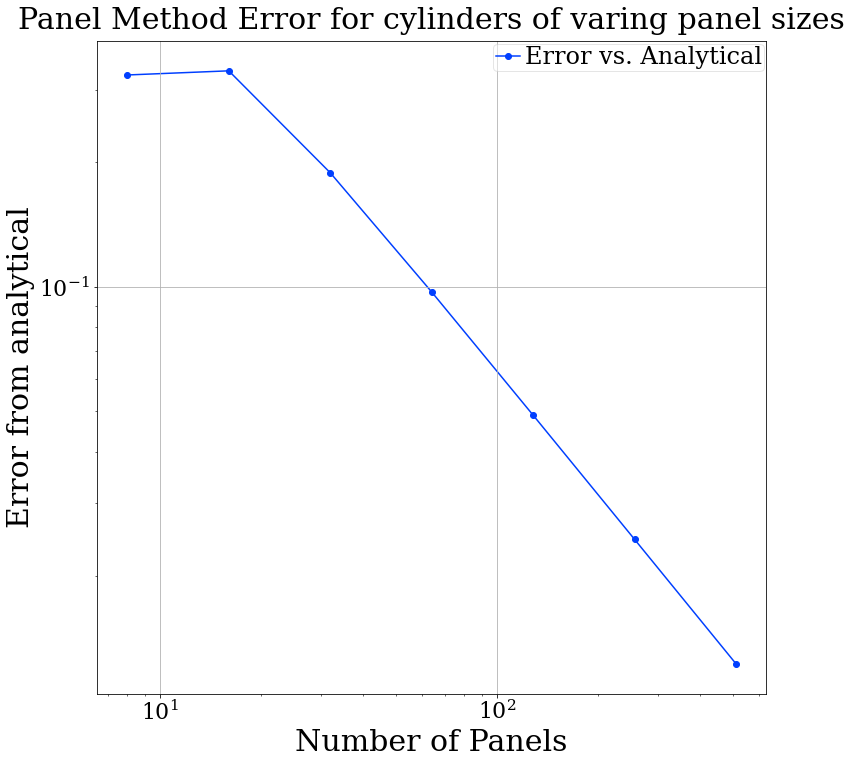

In [10]:
Nlist = [8, 16, 32, 64, 128, 256, 512]
errdat = np.empty((len(Nlist)))

for i, N in enumerate(Nlist):
    
    # Construct Cylinder panels
    x_cylinder, y_cylinder, panel_list = ConstructCylinder(0, 0, 1, N)
    
    # Solve for all data
    panel_list = PanelStrengthSolver(fs, panel_list)
    panel_list = PanelTangentSolver(fs, panel_list)
    panel_list = PanelPressureSolver(fs, panel_list)
    
    # Plot discretized pressure
    
    thetavec = np.empty((N, 1))
    cpvec = np.empty((N, 1))    

    for j, panel in enumerate(panel_list):
        thetavec[j] = np.arctan2(panel.yc, panel.xc)
        cpvec[j] = panel.surface_cp

    datavec = np.concatenate((thetavec, cpvec), axis=1)
    datavec = datavec[datavec[:, 0].argsort()]

    # Calculate error
    errdat[i] = (np.trapz(cp_analytical,
                    thetavec_analytical)
           - np.trapz(datavec[:, 1],
                      datavec[:, 0]))



fig, errplot = plt.subplots()

plothusly(errplot, Nlist, abs(errdat), xtitle='Number of Panels', ytitle='Error from analytical',
          title='Panel Method Error for cylinders of varing panel sizes',
          datalabel='Error vs. Analytical',
          marker='o')

plt.yscale('log')
plt.xscale('log')

Error decreases as a function of the number of panels used, with diminishing returns on error. The system becomes a tradeoff between required computational power/time, and accuracy of the system.

Plotting the velocity field for the 32 panel cylinder requires the system to be calculated for again. First, functions are defined to find the total velocity field with an arbitrary number of source panels, and a function to determine $C_P$ from that velocity field:

In [11]:
def CalculateVelocityField(X, Y, fs, panel_list):
    u = fs.u_inf * np.cos(fs.alpha) + X*0
    v = fs.u_inf * np.sin(fs.alpha) + X*0
    
    vector_I = np.vectorize(I)
    for panel in panel_list:
        u += panel.strength / (2*np.pi) * vector_I(X, Y, panel, 1, 0)
        v += panel.strength / (2*np.pi) * vector_I(X, Y, panel, 0, 1)
    
    return u, v

def CalculatePressureField(u, v, fs):
    Cp = 1 - (u**2 + v**2) / fs.u_inf**2
    return Cp

Determining for 32 panels:

Text(0.5, 1.0, 'Flow and Pressure diagram for 32 panel cylinder')

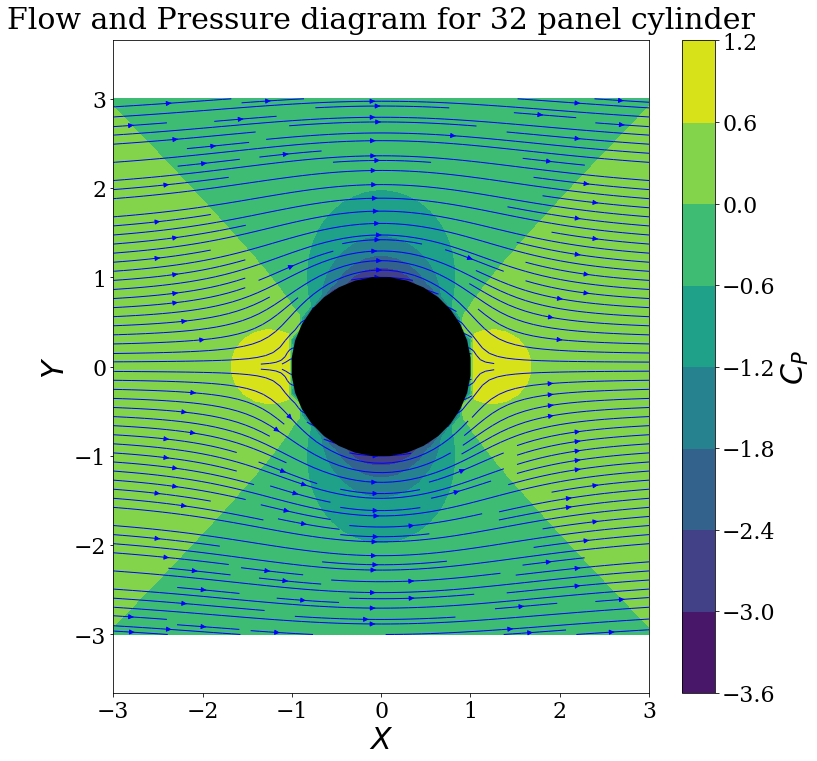

In [12]:
# Special Case for 32 Panels

N = 32

# Construct Cylinder panels
x_cylinder, y_cylinder, panel_list = ConstructCylinder(0, 0, 1, N)
    
# Solve for all data
panel_list = PanelStrengthSolver(fs, panel_list)
panel_list = PanelTangentSolver(fs, panel_list)
panel_list = PanelPressureSolver(fs, panel_list)
    
# Find flowfield

# meshgrid

x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)

X, Y = np.meshgrid(x, y)

u, v = CalculateVelocityField(X, Y, fs, panel_list)    

Cp = CalculatePressureField(u, v, fs)
# Plot it

fig, streamplot = plt.subplots()

plt.streamplot(X, Y, u, v, density = 2,
               linewidth = 1,
               color='blue',
               cmap=None,
               arrowsize=1)

plt.fill([panel.xc for panel in panel_list],
         [panel.yc for panel in panel_list],
         color='black',
         linestyle='-',
         linewidth=2,
         zorder=2)

plt.contourf(X, Y, Cp, cmap='viridis')

plt.axis('equal')

cbar = plt.colorbar()
cbar.set_label(r"$C_P$")

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'Flow and Pressure diagram for 32 panel cylinder')

Note that the pressure and flow fields are symmetrical across both the $x$ and the $y$ axis, which is expected in a potential flow field.

Pressure gradient for this cylinder is found simply by taking the gradient of the $C_P$ data:

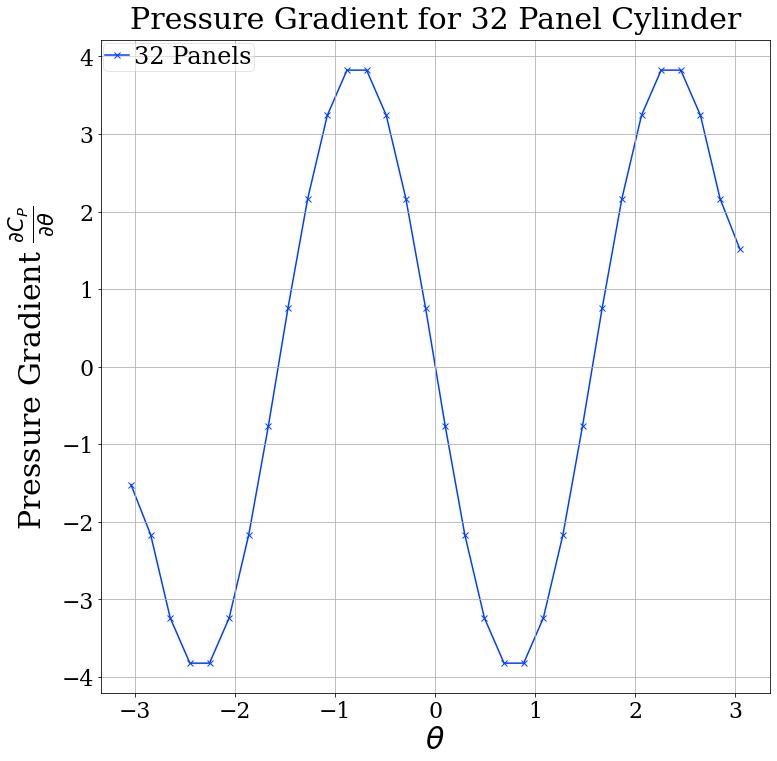

In [13]:
thetavec = np.empty((N, 1))
cpvec = np.empty((N, 1))
for i, panel in enumerate(panel_list):
    thetavec[i] = np.arctan2(panel.yc, panel.xc)
    cpvec[i] = panel.surface_cp
    
datavec = np.concatenate((thetavec, cpvec), axis=1)
datavec = datavec[datavec[:, 0].argsort()]

datavec[:, 1] = np.gradient(datavec[:, 1], datavec[:, 0])

fig, gradplot = plt.subplots()
plothusly(gradplot, datavec[:, 0], datavec[:, 1], xtitle=r'$\theta$', 
          ytitle=r'Pressure Gradient $\frac{\partial C_P}{\partial \theta}$',
          datalabel='32 Panels',
          title="Pressure Gradient for 32 Panel Cylinder",
          marker='x')

## 2 | Symmetric Airfoil

Using the previously made source-panel method, compute horizontal fluid flow over a NACA 0018 airfoil. Solve for surface pressure coefficient distribution, and compare to XFOIL results. Plot pressure contours and streamlines. 

Additionally, for a varying number of panels, find force coefficients for lift and drag. Determine to what number they converge to, and report and justify.

### 2.1 | Approach

The exact same approach can be used for the airfoil as for the cylinder, as the analysis functions were generalized for any arbitrary shape. The geometry is created from a function, which outputs a list of panels. The strengths of each panel is found using a linear system, and the tangential velocity is found at each point. Surface pressure coefficient can then be found from the tangent velocity, and then plotted. It can then be compared to XFOIL data on the same plot.

Similarly, the force coefficients can be found using integral functions from **Project 1**. From a large list of panel sizes, airfoils can be consecutively generated using larger and larger panel lengths. Using the resulting plot, it can be determined as to what number the coefficients converge to. 

### 2.2 | Equations

The same equations used in **Problem 1** are reused in **Problem 2**. They are restated here for convenience.

The source panel method is solved by the equation for the $i$-th panel:

$$\begin{equation}
    \frac{\lambda_i}{2} + \Sigma _{j=1, j\neq i} ^n \frac{\lambda_j}{2\pi} I_{i, j} + V_\infty cos \beta_i = 0
\end{equation}$$

where:

$$\begin{equation}
    I_{i, j} \int_j \frac{\partial}{\partial n} \ln r_{i,j} \, ds_j
\end{equation}$$

Source strength $\lambda_i$ is found using a system of linear equations:

$$\begin{equation}
    A\lambda = b
\end{equation}$$

for:
$$\begin{equation}
b_i = -V_\infty cos \beta_i
\end{equation}$$

Pressure is found as :

$$\begin{equation}
C_P = 1 - \frac{V^2}{V_\infty^2}
\end{equation}$$

Finally, the validity of the model can be checked by determining if there is a net change in the amount of fluid (that is, to see if mass is created or destroyed):

$$\begin{equation}
    \Sigma_{i=1}^{n} \lambda_i s_i = 0
\end{equation}$$

### 2.3 | Code and Results

An additional function is needed to create panel geometry for an airfoil. It uses the NACA airfoil generator function created for **Project 1**

In [14]:
def ConstructAirfoilPanels(xpoints, ypoints):
    N = len(xpoints) - 1
    panel_list = np.empty((N), dtype=object)
    # print("Airfoil Panel Points:")
    for i in range(N):
        # print(xpoints[i], ypoints[i
        panel_list[i] = Panel(xpoints[i], ypoints[i], xpoints[i+1], ypoints[i+1])
    # print(xpoints[i+1], ypoints[i+1])
    
    return panel_list

Once panel geometry is created, the airfoil can be solved for in the same manner as the cylinders. Pressure distributions for upper and lower surfaces are extracted and then plotted, and then compared to XFOIL data imported from a text file:

Sanity Check for NACA 0018 : [0.00459367]


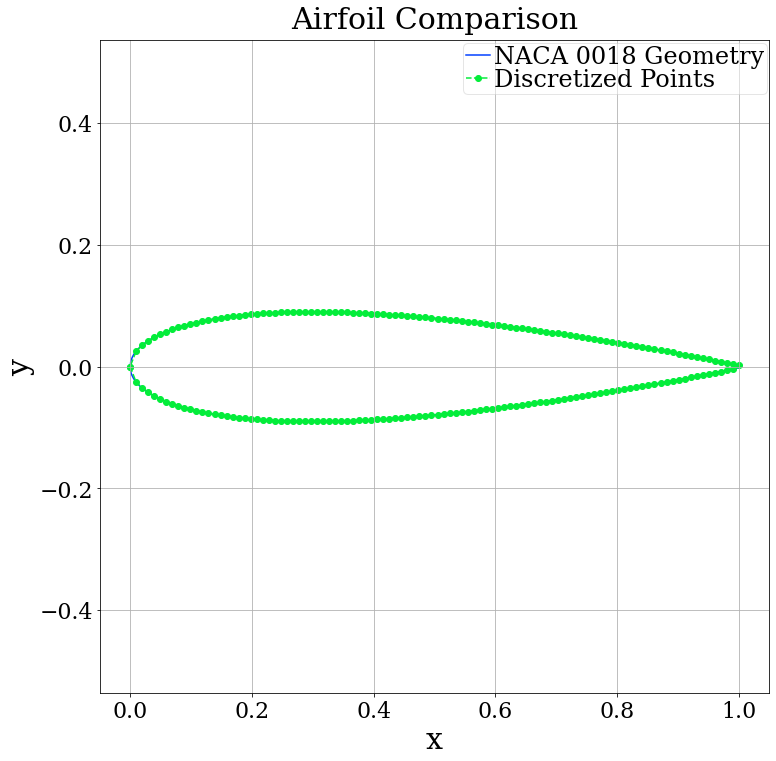

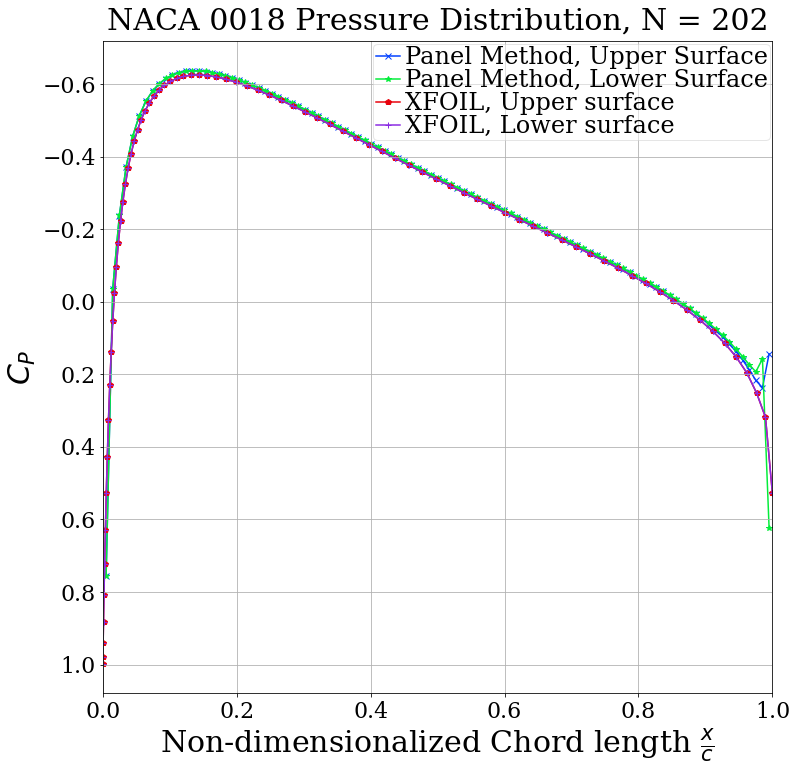

In [15]:
N = 102
xreal, zreal = NACAThicknessEquation(0, 0, 18, 1000)
x_panel_points, z_panel_points = NACAThicknessEquation(0, 0, 18, N)


# Fixes "Inside Out" problem
x_panel_points, z_panel_points = np.flip(x_panel_points), np.flip(z_panel_points)

panel_list = ConstructAirfoilPanels(x_panel_points, z_panel_points)

# Create plot and show the discretized airfoil vs the real one


panel_list = PanelStrengthSolver(fs, panel_list)
panel_list = PanelTangentSolver(fs, panel_list)
panel_list = PanelPressureSolver(fs, panel_list)
    
    
fig, foilplot = plt.subplots()

plothusly(foilplot, 
          xreal,
          zreal,
          xtitle='x',
          ytitle='y',
          title='Airfoil Comparison',
          datalabel='NACA 0018 Geometry')

plothus(foilplot,
        x_panel_points,
        z_panel_points,
        datalabel='Discretized Points',
        marker='o',
        linestyle='--')
plt.axis('equal')

sumval = 0
for i, panel in enumerate(panel_list):
    sumval += panel.strength * panel.length
    
    
# Get Data from XFOIL

airfoilflatLOlo = np.loadtxt("Data/naca0018ReLO0lower.text", skiprows=1)
airfoilflatLOhi = np.loadtxt("Data/naca0018ReLO0lower.text", skiprows=1)



print(f'Sanity Check for NACA 0018 : {sumval}')

pressure_list_upper = [panel.surface_cp.item() for panel in panel_list if panel.loc == 'upper']
pressure_x_upper = [panel.xc for panel in panel_list if panel.loc == 'upper']

fig, airfoilpressure = plt.subplots()
plothusly(airfoilpressure, 
          pressure_x_upper,
          pressure_list_upper,
          datalabel='Panel Method, Upper Surface',
          xtitle=r"Non-dimensionalized Chord length $\frac{x}{c}$",
          ytitle=r'$C_P$',
          title=fr'NACA 0018 Pressure Distribution, N = {len(panel_list)}',
          marker='x')

pressure_list_lower = [panel.surface_cp.item() for panel in panel_list if panel.loc == 'lower']
pressure_x_lower = [panel.xc for panel in panel_list if panel.loc == 'lower']

CL = CalculateCn(pressure_x_lower,
                 pressure_list_lower,
                 pressure_x_upper,
                 pressure_list_upper)

CD = CalculateCn(pressure_x_lower,
                 pressure_list_lower,
                 pressure_x_upper,
                 pressure_list_upper)

plt.xlim([0, 1])
plt.gca().invert_yaxis()

plothus(airfoilpressure,
        pressure_x_lower,
        pressure_list_lower,
        datalabel='Panel Method, Lower Surface',
        marker='*')


plothus(airfoilpressure,
        airfoilflatLOhi[:, 0],
        airfoilflatLOhi[:, 1],
        datalabel='XFOIL, Upper surface',
        marker='p'
        )


plothus(airfoilpressure,
        airfoilflatLOlo[:, 0],
        airfoilflatLOlo[:, 1],
        datalabel='XFOIL, Lower surface',
        marker='+'
        )

Note that the upper and lower surface pressure distributions are nearly identical, as expected on a symmetric airfoil. The data also closely aligns with the data generated by XFOIL.

Plotting fluid flow and pressure distribution over the airfoil:

In [16]:
x = np.linspace(-1.5, 1.5, 50)
y = np.linspace(-1.5, 1.5, 50)

X, Y = np.meshgrid(x, y)

u, v = CalculateVelocityField(X, Y, fs, panel_list)    

Cp = CalculatePressureField(u, v, fs)
# Plot it

fig, streamplot = plt.subplots()

plt.streamplot(X, Y, u, v, density = 2,
               linewidth = 1,
               color='blue',
               cmap=None,
               arrowsize=1)

plt.fill([panel.xc for panel in panel_list],
         [panel.yc for panel in panel_list],
         color='black',
         linestyle='-',
         linewidth=2,
         zorder=2)


plt.contourf(X, Y, Cp, cmap='viridis')
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label(r"$C_P$")


plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'Flow and Pressure diagram for NACA 0018')

KeyboardInterrupt: 

Note that the pressure distribution is symmetric about the x-axis.

Force coefficients and the value they converge to can then be determined by iterating over an increasing number of panels, and plotting the results.

In [ ]:
# Force Coefficients

Nlist = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 160, 200, 400]

# Nlist = [12, 20, 30, 40]
Cl = np.zeros((len(Nlist)))
Cd = np.zeros((len(Nlist)))

for i, N in enumerate(Nlist):
    x_panel_points, z_panel_points = NACAThicknessEquation(0, 0, 18, N)


    # Fixes "Inside Out" problem
    x_panel_points, z_panel_points = np.flip(x_panel_points), np.flip(z_panel_points)

    panel_list = ConstructAirfoilPanels(x_panel_points, z_panel_points)

    # Solve for panel data
    

    panel_list = PanelStrengthSolver(fs, panel_list)
    panel_list = PanelTangentSolver(fs, panel_list)
    panel_list = PanelPressureSolver(fs, panel_list)
    
    pressure_list_upper = [panel.surface_cp.item() for panel in panel_list if panel.loc == 'upper']
    pressure_x_upper = [panel.xc for panel in panel_list if panel.loc == 'upper']
    pressure_y_upper = [panel.yc for panel in panel_list if panel.loc == 'upper']
    
    pressure_list_lower = [panel.surface_cp.item() for panel in panel_list if panel.loc == 'lower']
    pressure_x_lower = [panel.xc for panel in panel_list if panel.loc == 'lower']
    pressure_y_lower = [panel.yc for panel in panel_list if panel.loc == 'lower']


    Cl[i] = CalculateCn(pressure_x_lower,
                        pressure_list_lower,
                        np.flip(pressure_x_upper),
                        np.flip(pressure_list_upper))

    Cd[i] = CalculateCa(pressure_x_lower,
                        pressure_list_lower,
                        pressure_x_upper,
                        pressure_list_upper,
                        pressure_x_lower, 
                        pressure_y_lower,
                        np.flip(pressure_y_upper))


# Create semilog plot

fig, liftplot = plt.subplots()

plothusly(liftplot, Nlist, Cl, datalabel=r'$C_l$', xtitle='Number of panels',
          ytitle='Coefficient Value', title='Force Coefficients for increasing panel number',
          marker='x')

plothus(liftplot, Nlist, Cd, datalabel=r'$C_d$', marker='+')
plt.xscale('log')


The values do not correctly converge, likely due to the result of an error in the integration function. They do, however, approach zero. For a truly inviscid, potential flow for a horizontal airfoil, it would be expected that both flows converge to zero. 

## 3 | Additional Problems

### 3.1 | Irrotationality 

Show that a point source potential flow is, in fact, irrotational.

#### 3.1.1 | Approach

Using the stream function for source potential flow, solve Laplace's equation. As the flow is incompressible, if it is also irrotational, Laplace's equation will be satisfied.

#### 3.1.2 | Equations

Stream function for a source flow is given as:

$$\begin{equation}
    \psi = \frac{\Lambda}{2\pi}\theta
\end{equation}$$

Laplace's equation for cylindrical coordinates is expressed as:

$$\begin{equation}
    \nabla^2 f = \frac{1}{r} \frac{\partial}{\partial r} (r \frac{\partial f}{\partial r}) + \frac{1}{r^2} \frac{\partial^2 f}{\partial \theta^2}
\end{equation}$$

#### 3.1.3 | Code and Results

Taking the Laplacian of $\psi$:


$$\begin{equation}
    \nabla^2 \psi = \frac{1}{r} \frac{\partial}{\partial r} (r \frac{\partial \psi}{\partial r}) + \frac{1}{r^2} \frac{\partial^2 \psi}{\partial \theta^2}
\end{equation}$$

Determining each term:

$$\begin{equation}
    \frac{\partial \psi}{\partial r} = \frac{\partial}{\partial r} (\frac{\Lambda}{2\pi}\theta) = 0
\end{equation}$$

$$\begin{equation}
    \frac{\partial^2 \psi}{\partial \theta^2} = \frac{\partial^2 }{\partial \theta^2}(\frac{\Lambda}{2\pi}\theta) = \frac{\partial }{\partial \theta}(\frac{\Lambda}{2\pi}) = 0
\end{equation}$$

Therefore:

$$\begin{equation}
    \nabla^2 \psi = 0 + 0 = 0
\end{equation}$$

Because Laplace's equation is satisfied, the flow is irrotational at all points. 

### 3.2 | Boundary Layers

Show, via equation, that no boundary layer is irrotational.

#### 3.2.1 | Approach

Show that the boundary layer is irrotational given the equation for vorticity, and the definition of a boundary layer.

#### 3.2.2 | Equations

Vorticity is given in 2D as:

$$\begin{equation}
    \zeta = 2\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{equation}$$

#### 3.2.3 | Code and Results

A boundary layer is caused as the result of the shear force caused by a surface.

Conisder a wall parallel to the $x$ axis, with fluid flowing in the $x$ direction. As the only force on the fluid is in the $-x$ direction, $v$ does not variy with the $x$ direction. Therefore:

$$\begin{equation}
    \frac{\partial v}{\partial x} = 0
\end{equation}$$

Recall the equation for vorticity:

$$\begin{equation}
    \zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{equation}$$

As $\frac{\partial v}{\partial x} = 0$, $\zeta$ is non-zero, and is equal to:

$$\begin{equation}
    \zeta = - \frac{\partial u}{\partial y}
\end{equation}$$

Therefore, no boundary layer is irrotational.

### 3.3 | Potential Flow

For a potential uniform and source flow, derive the equation for the distance from the source location in which radial velocity is $\frac{1}{3}$ freestream velocity.

#### 3.3.1 | Approach

Use the same method as used to find the stagnation point, except with $V_\theta = \frac{1}{3} V_\infty$.

#### 3.3.2 | Equations

All derivations required for this problem are derived from stream function $\psi$:

$$\begin{equation}
    \psi = V_\infty \, r \, sin \, \theta + \frac{\Lambda}{2\pi}\theta
\end{equation}$$

#### 3.3.3 | Code and Results

Rotational velocity $V_\theta$ can be found as the negative of the partial derivtive of the stream function $\psi$:

$$\begin{equation} 
    V_\theta = - \frac{\partial \psi}{\partial r} = - \frac{\partial}{\partial r} (V_\infty \, r \, sin \, \theta + \frac{\Lambda}{2\pi}\theta)
\end{equation}$$

$$\begin{equation} 
    V_\theta = -V_\infty \, sin \, \theta 
\end{equation}$$

Evaluating at $\theta = 90^o = \frac{\pi}{2}$:

$$\begin{equation} 
    V_\theta = -V_\infty
\end{equation}$$

$V_\theta$ does not vary as a function of $r$, and therefore at no point does $V_\theta = \frac{1}{3} V_\infty$.

### 3.4 | Circular Cylinder

For a cylindrical strut on the nose of a 747, estimate the pressure on the leading edge of the strut, and at 45 degrees from the leading edge, for a 12 inch radius,, an altitude of 20,000 ft, standard atmosphere, and an airspeed of 185 knots.

#### 3.4.1 | Approach

Using panel method, solve for a cylinder of the appropriate size, and find $C_P$ values. Using the equation for $C_P$, and the properties given in the problem statement, local pressure $P$ can be found.

#### 3.4.2 | Equations

$C_P$ is given as:

$$\begin{equation}
    C_P = \frac{P - P_\infty}{0.5\rho_\infty V_\infty^2}
\end{equation}$$

Rearranged to find $P$:

$$\begin{equation}
    P = \frac{1}{2}\rho_\infty V_\infty^2 (C_P + P_\infty) 
\end{equation}$$

#### 3.4.3 | Code and Results

$P_\infty$ and $\rho_\infty$ can be found using a table for standard atmosphere. The local pressure coefficient can be found by interpolating from existing panels. An anonymous function can then be used to find the local pressure value.

In [ ]:
# Problem 3.4

Nlist = [128]

fs = Freestream(312.245, 0)

for N in Nlist:
    
    # Construct Cylinder panels
    x_cylinder, y_cylinder, panel_list = ConstructCylinder(0, 0, 1, N)
    
    # Solve for all data
    panel_list = PanelStrengthSolver(fs, panel_list)
    panel_list = PanelTangentSolver(fs, panel_list)
    panel_list = PanelPressureSolver(fs, panel_list)
    
    # Plot discretized pressure
    
    thetavec = np.empty((N, 1))
    cpvec = np.empty((N, 1))
    for i, panel in enumerate(panel_list):
        thetavec[i] = np.arctan2(panel.yc, panel.xc)
        cpvec[i] = panel.surface_cp
    
    datavec = np.concatenate((thetavec, cpvec), axis=1)
    datavec = datavec[datavec[:, 0].argsort()]

Pamb = 2116.23  # lbf/ft**2
rho = 0.00237717  # slug/ft**3
v_inf = 312.245  # ft/s

Pfind = lambda Cp: ((Cp + Pamb) * (0.5 * rho * v_inf**2))

Cp0 = np.interp(0, datavec[:, 0], datavec[:, 1])
Cp45 = np.interp(np.pi/4, datavec[:, 0], datavec[:, 1])

print(f'Pressure at 0 deg is {Pfind(Cp0)} lbf/sqft')
print(f'Pressure at 45 deg is {Pfind(Cp45)} lbf/sqft')

## 4 | Conclusion

Source panel method is a viable way to model fluid flow around arbitrary closed geometry, but requires a high number of panels to be accurate. As the number of panels increases, the computational power required to solve the system increases exponentially (approximately $n^3$ calculations for a matrix of $n$ size). It is a good model for 2D inviscid fluid flow across a cambered airfoil, but would be unable to correctly model a viscid flow. As such, it would be useful for a general picture of how fluid would flow across an object, but not particularly useful for any precise work involving real, viscous fluids.